# Análisis de candidatos y sentimientos
En este script se analizan candidatos y sentimientos asociados a través de modelos LLM y validación semi-asistida   

In [7]:
import pandas as pd

# Cargo el df y elimino duplicados
df = pd.read_csv('../data/processed/noticias_limpias.csv')
print(df.shape)

# Opcional: eliminar duplicados por enlace o título
df = df.drop_duplicates(subset=['enlace'])
print(df.shape)

# Visualizar algunos casos
print(df.sample(5)[['titulo', 'fecha', 'contenido', 'medio']])

# Columnas
df.columns


(760, 13)
(759, 13)
                                                titulo                fecha  \
689  Nuevo acuerdo con el FMI: el desembolso en 202...  2025-04-12 05:00:00   
219  El gobierno convocó a los gremios estatales a ...  2025-07-17 17:57:00   
39                 Entre Ríos se destaca en Agroactiva  2025-06-06 00:00:00   
570  Gobernadores, funcionarios y académicos partic...  2025-05-06 05:30:00   
733  En el cierre de la semana, el Banco Central de...  2025-03-08 06:00:00   

                                             contenido      medio  
689  El directorio del Fondo Monetario Internaciona...  elheraldo  
219  El gobierno provincial oficializó la convocato...   analisis  
39   La feria a cielo abierto más importante de Amé...   eldiario  
570  La actividad reunirá a referentes del sector p...  elheraldo  
733  El Banco Central debió vender US$ 224 millones...  elheraldo  


Index(['enlace', 'seccion', 'pagina', 'fecha', 'titulo', 'contenido', 'vistas',
       'categorias', 'medio', 'descripcion', 'copete', 'texto_completo',
       'texto_limpio'],
      dtype='object')

In [12]:
# Buscá menciones de Frigerio (con variantes)
def menciona_michel(texto):
    variantes = ["rogelio frigerio", "frigerio"]
    return any(var in texto for var in variantes)

df['es_frigerio'] = df['texto_limpio'].apply(menciona_michel)
df_michel = df[df['es_frigerio']]
print(f"Noticias que mencionan a Frigerio: {df_michel.shape[0]}")

Noticias que mencionan a Frigerio: 57


In [19]:
import pysentimiento

# --- 4. Inicializar el analizador de sentimiento ---
analyzer = pysentimiento.create_analyzer(task="sentiment", lang="es")

# --- 5. Función para predecir sentimiento ---
def sentimiento(texto):
    r = analyzer.predict(str(texto))
    return r.output  # 'POS', 'NEG', 'NEU'

# --- 6. Aplicar el análisis de sentimiento ---
df_michel['sentimiento'] = df_michel['texto_limpio'].apply(sentimiento)

# --- 7. Ver distribución de sentimientos ---
print(df_michel['sentimiento'].value_counts())


sentimiento
NEU    24
NEG    19
POS    14
Name: count, dtype: int64


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8648\3826631203.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_michel['sentimiento'] = df_michel['texto_limpio'].apply(sentimiento)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8648\476928354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_michel['fecha_publicacion'] = pd.to_datetime(df_michel['fecha'])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_8648\476928354.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_michel['semana'] = df_michel['fecha_publicacion'].dt.to_period('W').astype(str)


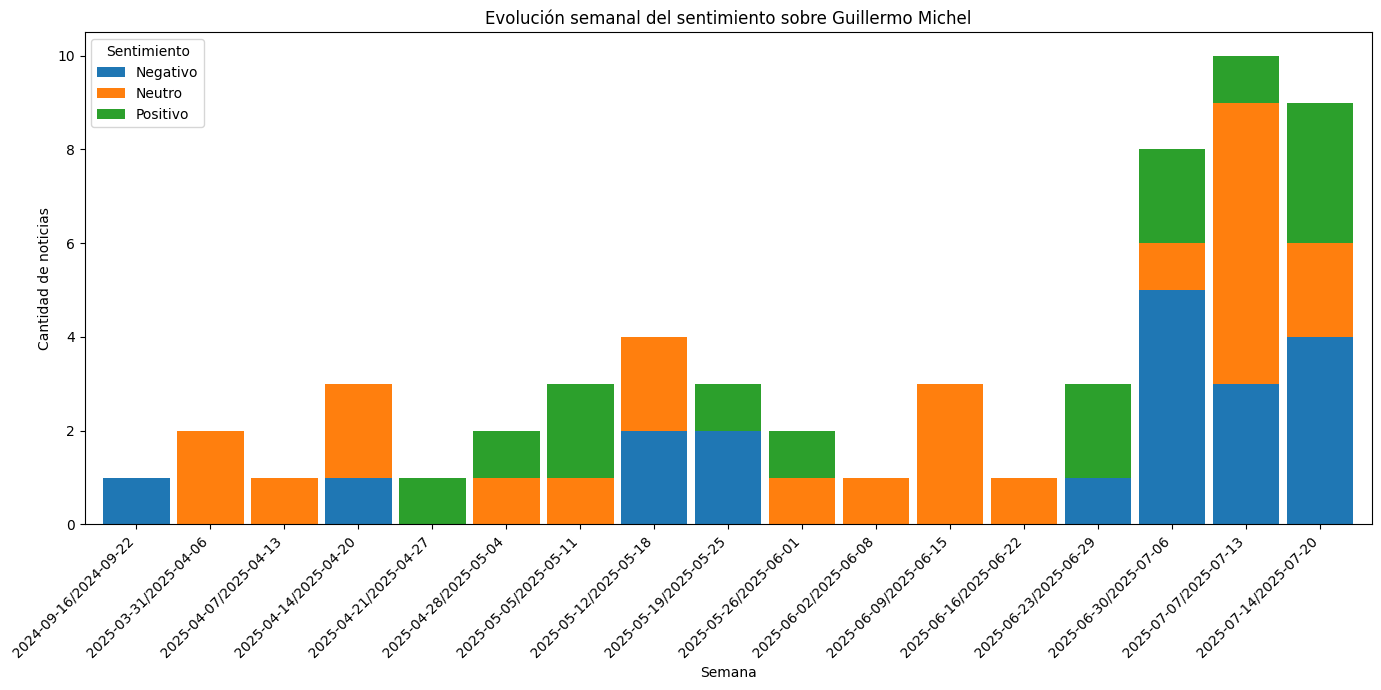

In [22]:
import matplotlib.pyplot as plt

# 6. Asegurá que la columna de fecha sea datetime
df_michel['fecha_publicacion'] = pd.to_datetime(df_michel['fecha'])

# 7. Crear columna de semana
df_michel['semana'] = df_michel['fecha_publicacion'].dt.to_period('W').astype(str)

# 8. Agrupar y pivotear por semana y sentimiento
evolucion = df_michel.groupby(['semana', 'sentimiento']).size().unstack(fill_value=0)
evolucion = evolucion.sort_index()
evolucion = evolucion.rename(columns={"POS":"Positivo", "NEG":"Negativo", "NEU":"Neutro"})

# 9. Graficar barras apiladas
ax = evolucion.plot(kind='bar', stacked=True, figsize=(14,7), width=0.9)
plt.title("Evolución semanal del sentimiento sobre Guillermo Michel")
plt.ylabel("Cantidad de noticias")
plt.xlabel("Semana")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Sentimiento")
plt.tight_layout()
plt.show()

In [25]:
# Selecciona 20 ejemplos al azar
muestra = df_michel.sample(20, random_state=42)

# Mostralos en pantalla con las columnas que te interesan
print(muestra[['fecha', 'titulo', 'copete', 'contenido', 'sentimiento']])

muestra.to_csv("revision_sentimiento_michel.csv", index=False)


                   fecha                                             titulo  \
8    2025-07-15 00:00:00  Frigerio recorrió una obra de electrificación ...   
52   2025-05-13 00:00:00  En la Jonagro, Frigerio llamó a pensar en una ...   
265  2025-07-08 17:27:00  “Mejorar la eficiencia del Estado”, fue el tem...   
81   2025-04-10 00:00:00  Frigerio: “En un año, salvamos la Caja de Jubi...   
292  2025-07-03 07:30:00  Baja en el gabinete de Frigerio: renunció Giar...   
571  2025-05-06 00:30:00  Frigerio analizó prioridades de gestión con Di...   
261  2025-07-09 21:13:00  "Los índices de recaudación son similares a lo...   
278  2025-07-06 16:01:00  Guillermo Michel: “Rogelio Frigerio y Javier M...   
465  2025-06-17 07:30:00  Julián Maneiro será el nuevo Secretario de Jus...   
80   2025-04-15 00:00:00  Rogelio Frigerio dispone la nulidad de 770 con...   
495  2025-06-03 20:00:00  Frigerio gestionó la reactivación de obras del...   
36   2025-06-10 00:00:00  Frigerio presentó nuevos v